In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib
import os.path
from messaging.telegrambot import Bot
import telegram

In [2]:
#Testing telegrambot
chat_id = '238145629'
my_token = '454077513:AAHbucnYOQM-CDIWEO3lgk_iaQ_9Lpj18b8'
bot = telegram.Bot(token=my_token) # inicia o bot
bot.sendMessage(chat_id, text="Testing!")


In [197]:
saveFigDir = results_path+'Figures/'+dataset
saveName = 'SVD-MAE'
print saveFigDir

./Results/Figures/100k/


In [207]:
bot = Bot('JFGS')
message = 'MAE-SVD'
saveFigDir = results_path+'Figures/'+dataset
saveName = 'SVD-MAE'
imgPath = '{}/{}.{}'.format(saveFigDir, saveName, 'png')
#filePath = '{}/{}.{}'.format(saveFigDir, saveName, 'pdf')
bot.sendMessage(message, imgPath)


<h1>Loading Dataset</h1>

There are 3 movieLens datasets available: the 100k, 10M and 20M datasets. To choose one of them, just simply uncomment the 'dataset_path' variable according to the respective folder 

In [3]:
#Loading dataset

dataset = '100k/' #100k dataset path
#dataset = '10M/' #10M dataset path
#dataset = '20M/' #20M dataset path

dataset_path = '../../Datasets/movieLens/' + dataset; # Full dataset path

filenames = {'movie': 'movie.csv', 'rating': 'rating.csv'};

time_zero = time.time();
#df_movies = pd.read_csv(dataset_path+filenames['movie'], error_bad_lines=False);
#print "[Loading Time:",time.time()-time_zero,"s]",filenames['movie'],'Shape: ', df_movies.shape;

#print df_movies.head();
#print df_movies.tail();

global df_ratings;
df_ratings = pd.read_csv(dataset_path+filenames['rating']);
print "[Loading Time:",time.time()-time_zero,"s]",filenames['rating'],'Shape: ', df_ratings.shape;


[Loading Time: 0.0587720870972 s] rating.csv Shape:  (100000, 4)


In [3]:
print df_ratings.info();
print df_ratings.head();
print df_ratings.tail();


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
userId       100000 non-null int64
movieId      100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB
None
   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596
       userId  movieId  rating  timestamp
99995     880      476       3  880175444
99996     716      204       5  879795543
99997     276     1090       1  874795795
99998      13      225       2  882399156
99999      12      203       3  879959583


<h1>Creating Users and Movies IDs array</h1>
We create two arrays containing:
- Each UserID
- Each MovieID
<p>After running the following cell, it is expected to find: 69878 users and 10677 movies
<p> Aproximate elapsed time: 400s (~6min)

In [4]:
global usersIds;
global moviesIds;

def InitializeIds():
    global usersIds;
    global moviesIds;


    usersIds = np.zeros(1);
    moviesIds = np.zeros(1);


    for count in xrange(len(df_ratings['rating'])):

        if df_ratings['userId'][count] in usersIds:
            pass;
        else:
            usersIds = np.append(usersIds, df_ratings['userId'][count]);   

        if df_ratings['movieId'][count] in moviesIds:
            pass;
        else:
            moviesIds = np.append(moviesIds, df_ratings['movieId'][count]);
            currentMovieId = df_ratings['movieId'][count];


In [5]:
#Counting Number of Unique Users and Movies
time_zero = time.time();

InitializeIds();            
            
print "Users Ids array:\t",usersIds.shape
print "Movies Ids array:\t", moviesIds.shape;
print "Elapsed time: ", time.time()-time_zero; # Aprox. 370 s

Users Ids array:	(944,)
Movies Ids array:	(1683,)
Elapsed time:  5.83887195587


<h1>Creating Utility Matrix R</h1>
<p>Our Utility Matrix will have <b>users as lines</b> and <b>movies as columns</b>. 

In [6]:
# Auxiliary Functions
global R;
global results_path;
results_path = './Results/';

def InitializeUtilityMatrix():
    InitializeIds();
    return np.zeros((usersIds.shape[0], moviesIds.shape[0]));

def FillUtilityMatrix():
    global R;
    for register in xrange(len(df_ratings['userId'])):
        userId = df_ratings['userId'][register];
        movieId = df_ratings['movieId'][register];

        #Getting userIndex from usersIds
        #itemindex = numpy.where(array==item) --> Return an array with indexes found
        userIndex = np.where(usersIds == userId);
        if len(userIndex[0]) == 0: # If userIndex hasn't found any matching user id in usersIds array
            print "UserId", userId, "not found in usersIds array.";
            pass;
        else:
            try:
                if len(userIndex[0]) > 1:
                    print "UserId ", userId, "is double-counted in usersIds.";
                userIndex = userIndex[0][0]; #Get the first occurance of userId match
            except IndexError:
                print "Error with user index: ", userIndex[0] ;
                pass;


        #Getting movieIndex from moviesIds
        #itemindex = numpy.where(array==item) --> Return an array with indexes found
        movieIndex = np.where(moviesIds == movieId);
        if len(movieIndex[0]) == 0: # If userIndex hasn't found any matching user id in usersIds array
            print "MovieId", movieId, "not found in usersIds array.";
            pass;
        else:
            try:
                if len(movieIndex[0]) > 1:
                    print "MovieId ", movieId, "is double-counted in moviesIds.";
                movieIndex = movieIndex[0][0]; #Get the first occurance of movieId match
            except IndexError:
                print "Error with movie index: ", movieIndex[0] ;
                pass;            

        R[userIndex][movieIndex] = df_ratings['rating'][register];
        
    return R;

def saveVariable(filename, variable):
    
    compression_parameter = 9;
    
    filepath = results_path+"Variables/"+dataset+filename;
    print "[*] Saving variable to " + filepath + " file...";
    if os.path.isfile(filepath): #Check if file already exists
        print "[*] Removing existing file...";
        os.remove(filepath);
        print "[+] Existing file removed.";    

    #joblib.dump(value, filename, compress=0, protocol=None, cache_size=None)
    joblib.dump(variable, filepath, compress = compression_parameter);
    print "[+] File saved.";   


In [7]:
import sys

time_zero = time.time();

R = InitializeUtilityMatrix();
R = FillUtilityMatrix();

print "Utility Matrix shape: ", R.shape;

KILO = 1000.0
MEGA = 1000*KILO;
GIGA = 1000*MEGA
print "Utility Matrix Memory Usage: ", sys.getsizeof(R)/(KILO)

#Saving variable
filename = 'originalUtilityMatrix';
print "[*] Saving original utility variable..."
saveVariable(filename, R); # saveVariable(filename, variable):
print "[+] Variable saved."


print "Elapsed time: ", time.time() - time_zero;

Utility Matrix shape:  (944, 1683)
Utility Matrix Memory Usage:  12710.128
[*] Saving original utility variable...
[*] Saving variable to ./Results/Variables/100k/originalUtilityMatrix file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[+] Variable saved.
Elapsed time:  11.1711349487


In [11]:
#########################################################################
# RUN THIS CELL IN CASE YOU HAVE 
# MEMORY PROBLEMS INITIALIZING UTILITY MATRIX.
# This cell can give you an estimate of how big your matrix can be given 
# an specific server memory
##########################################################################
# time_zero = time.time();

#print "#Users: ", usersIds.shape[0];
#print "#Movies: ", moviesIds.shape[0];
#R = np.zeros((usersIds.shape[0], moviesIds.shape[0]));

#R = np.zeros((usersIds.shape[0], moviesIds.shape[0]))
#R = np.zeros((138493, 26744))

# for count in xrange(moviesIds.shape[0]):
#     try:
#         R = np.zeros((usersIds.shape[0],count));
#     except MemoryError: 
#         print "Error in ", count, "iteration";
#         break;

# print "Elapsed time: ", time.time()-time_zero; 
# print "Matrix R shape: ",R.shape;


<h1>Visualizing the Original Utility Matrix Sparsity</h1>
<p>To get a glimpse of how sparse our utility matrix is, we use the <b>plt.spy()</b> function.

In [8]:
# Auxiliary Functions 

def calculateOverallSparsityMeasure(matrix):
    """Calculates the Overall Sparsity (OS) Measure based on:
        OS = 1 - #evaluations/(#user * #items)"""
    numberOfEvaluations = 0;
    
    for user in matrix:
        numberOfEvaluations += np.count_nonzero(user);      
        
    try:
        if (matrix.shape[0] != 0 and matrix.shape[1] != 0):
            return 1 - float(numberOfEvaluations)/float(matrix.shape[0]*matrix.shape[1])
        else:
            return 0;
    except:
        pass;

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.61582493782


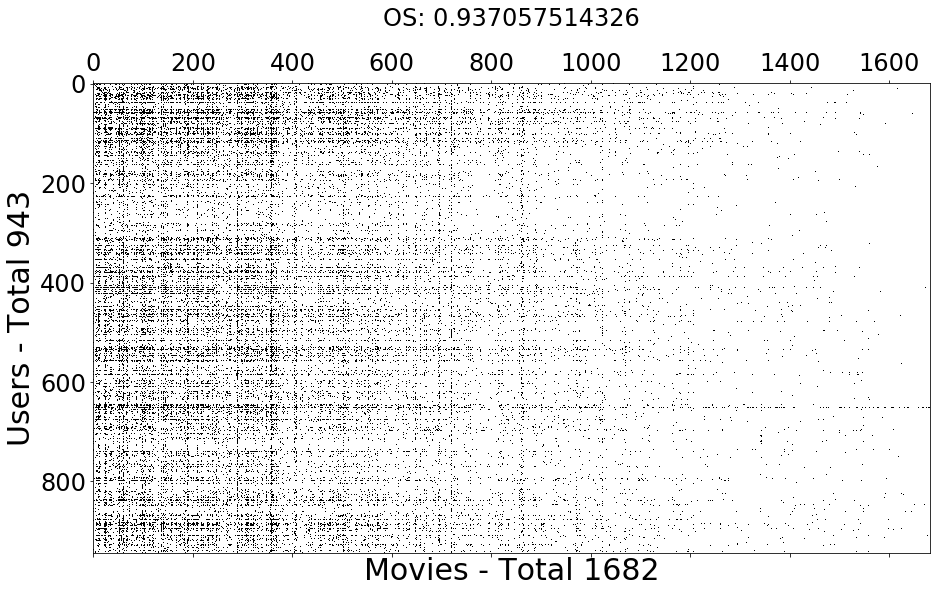

In [9]:
# Visualizing Matrix Sparsity
time_zero = time.time();

%matplotlib inline

OS = calculateOverallSparsityMeasure(R);

fig, ax = plt.subplots(figsize = (15,15));

ax.spy(R);

plt.xlabel("Movies - Total "+str(R.shape[1]-1), fontsize = 30)
plt.ylabel("Users - Total "+str(R.shape[0]-1), fontsize = 30)
plt.title("OS: " + str(OS) + '\n', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=24)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'unsortedUtilityMatrix.png')

print "[+] Results saved."

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h1>Sorting Utility Matrix</h1>
<p>In order to study how sparsity can influence our algorithm, we need to create an utility matrix in a way that it is more dense near low indexes elements (top left corner of matrix) and less dense new high indexes elements (bottom right corner). This will give us the ability to chop the matrix on a given sparsity measure.

In [10]:
#Auxiliary Functions

global usersSparsity;
global usersSortedFlag;
global itemsSparsity;
global itemsSortedFlag;

def InitializeUsersSparsity():
    global usersSparsity;
    global usersSortedFlag;
    usersSparsity = np.zeros(R.shape[0]);
    usersSortedFlag = False; # If users are sorted by USS, flag turns True
    
def InitializeItemsSparsity():
    global itemsSparsity;
    global itemsSortedFlag; 
    itemsSparsity = np.zeros(R.shape[1]);
    itemsSortedFlag = False;

<h2>Sorting Users</h2>
<p>We start sorting our users given the following user specific sparsity measure (USS) as follows: 
<p> $USS = 1-\frac{n_u}{\max{u \in U} (n_u)}$
<p>where $n_u$ is the amount of evaluations a specific user $u$ has given $U$.

In [11]:
# Auxiliary Functions
def calculateUsersSpecificSparsityMeasure(matrix):
    """Calculates an array of User Specific Sparsity (USS) measure based on:
        USS = 1 - #u / max (#u), where #u is the number of items rated
        by user u"""
    ussArray = np.zeros(matrix.shape[0]);
    
    count = 0;
    for user in matrix:
        ussArray[count] = np.count_nonzero(user);
        count += 1;
        
    maxNumberOfEvaluations = np.amax(ussArray)
    count = 0;
    for user in ussArray:
        ussArray[count] = 1-float(ussArray[count])/maxNumberOfEvaluations;
        count += 1;
        
    return ussArray;

def sortUsersBySparsity(matrix): #returns matrix, usersSortedIndex;
    """ Sort Utility Matrix by Users Sparsity
        Returns sorted matrix and usersSparsity array"""
    global usersSparsity;
    global usersSortedFlag;
    if not usersSortedFlag:
        print "Calculando...";
        usersSparsity = calculateUsersSpecificSparsityMeasure(matrix);
        usersSortedFlag = True;
        
    usersSortedIndex = np.argsort(usersSparsity);
    
    global usersIds;
    usersIds = usersIds[usersSortedIndex];
    matrix = matrix[usersSortedIndex];
    
    return matrix;

In [98]:
#########################################################
# Run this cell if you want to reset
# the utility matrix
#########################################################
time_zero = time.time();

R = InitializeUtilityMatrix();
R = FillUtilityMatrix();
InitializeUsersSparsity(); # Set usersSortedFlag to False
print "Elapsed time: ", time.time()-time_zero;

Elapsed time:  6.07619595528


In [12]:
# Initializing users sparsity array
time_zero = time.time();
InitializeUsersSparsity(); # Set usersSortedFlag to False

print "Elapsed time: ", time.time()-time_zero;

Elapsed time:  0.000444889068604


In [13]:
# Sorting Users by Sparsity
time_zero = time.time();

# Calculating users specific sparsity array
if not usersSortedFlag:
    usersSparsity = calculateUsersSpecificSparsityMeasure(R);
    usersSortedFlag = True;

# Saving USS Variables
saveVariable('usersSparsityArray', usersSparsity);

R = sortUsersBySparsity(R);

print "Utility Matrix sorted by users.";
print "Utility Matrix shape: ", R.shape;

print "Elapsed time: ", time.time()-time_zero;

# 100k Aprox. 3 s
# 10M Aprox. 27000 s

[*] Saving variable to ./Results/Variables/100k/usersSparsityArray file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
Utility Matrix sorted by users.
Utility Matrix shape:  (944, 1683)
Elapsed time:  0.0289480686188


<h3>Visualizing Users-Sorted Utility Matrix</h3>

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.466424942017


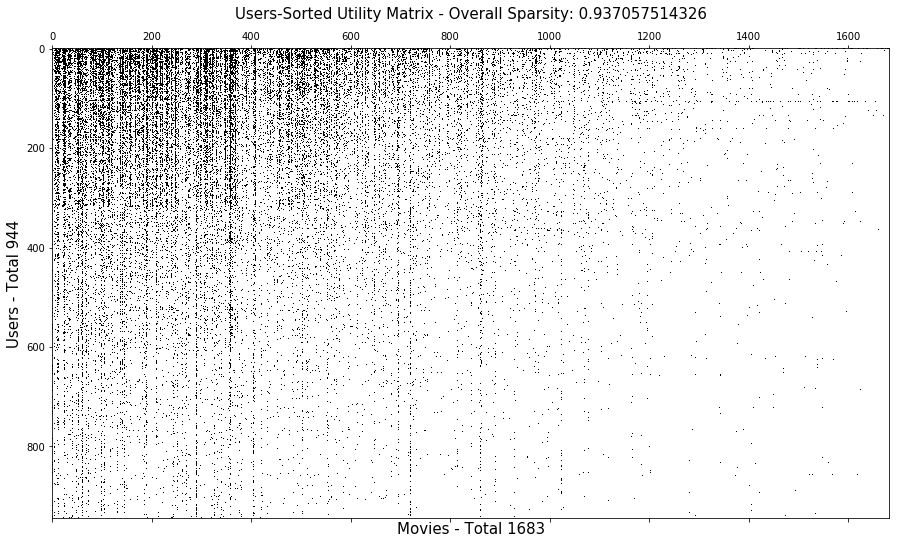

In [14]:
# Visualizing Users Sorted Matrix Sparsity
time_zero = time.time();

%matplotlib inline

OS = calculateOverallSparsityMeasure(R);
fig, ax = plt.subplots(figsize = (15,15));

ax.spy(R);

plt.xlabel("Movies - Total "+str(R.shape[1]), fontsize = 15)
plt.ylabel("Users - Total "+str(R.shape[0]), fontsize = 15)
plt.title("Users-Sorted Utility Matrix - Overall Sparsity: " + str(OS), fontsize = 15)

# Saving Figure
print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'usersSortedUtilityMatrix.png')

print "[+] Results saved."

plt.title("Users-Sorted Utility Matrix - Overall Sparsity: " + str(OS), fontsize = 15)

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h2>Sorting Items</h2>

<p>We then move to sorting our items given the following item specific sparsity measure (ISS) as follows: 
<p> $ISS = 1 - \frac{n_i}{\max{i \in I} (n_i)}$
<p>where $n_i$ is the amount of evaluations a specific user $u$ has given $I$.

In [16]:
def calculateItemsSpecificSparsityMeasure(matrix):
    """Calculates an array of Items Specific Sparsity (ISS) measure based on:
        ISS = 1 - #i / max (#i), where #i is the number of users who rated
        item u"""
    
    issArray = np.zeros(np.transpose(matrix.shape[0]));
    issArray = calculateUsersSpecificSparsityMeasure(np.transpose(matrix));
    
    return issArray;


def sortItemsBySparsity(matrix): #returns matrix, itemsSparsity;
    """ Sort Utility Matrix by Items Sparsity
        Returns sorted matrix and itemsSparsity array"""
    global itemsSparsity;
    global itemsSortedFlag;
    if not itemsSortedFlag:
        itemsSparsity = calculateItemsSpecificSparsityMeasure(matrix);
        itemsSortedFlag = True;
    
    itemsSortedIndex = np.argsort(itemsSparsity);
    
    global moviesIds;
    moviesIds = moviesIds[itemsSortedIndex];
    matrix = (matrix.T[itemsSortedIndex]).T;    
    
    return matrix;

In [17]:
#########################################################
# Run this cell if you want to reset
# the utility matrix
#########################################################
# time_zero = time.time();

# R = InitializeUtilityMatrix();
# R = FillUtilityMatrix();
# print "Elapsed time: ", time.time()-time_zero;

In [18]:
# Initializing Items Sparsity Array    
time_zero = time.time();

InitializeItemsSparsity(); # Set itemsSortedFlag to False

print "Elapsed time: ", time.time()-time_zero;

Elapsed time:  0.000158071517944


In [19]:
time_zero = time.time();

# Calculating users specific sparsity array
if not itemsSortedFlag:
    itemsSparsity = calculateItemsSpecificSparsityMeasure(R);
    itemsSortedFlag = True;

# Saving sorted users specific sparsity array
saveVariable('itemsSparsityArray', itemsSparsity);

R = sortItemsBySparsity(R);

print "Elapsed time: ", time.time()-time_zero;

# 100k Aprox. 166 s
# 10M Aprox. 27000 s

[*] Saving variable to ./Results/Variables/100k/itemsSparsityArray file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
Elapsed time:  0.0638408660889


<h3>Visualizing Items-Sorted Utility Matrix</h3>

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  1.20803999901


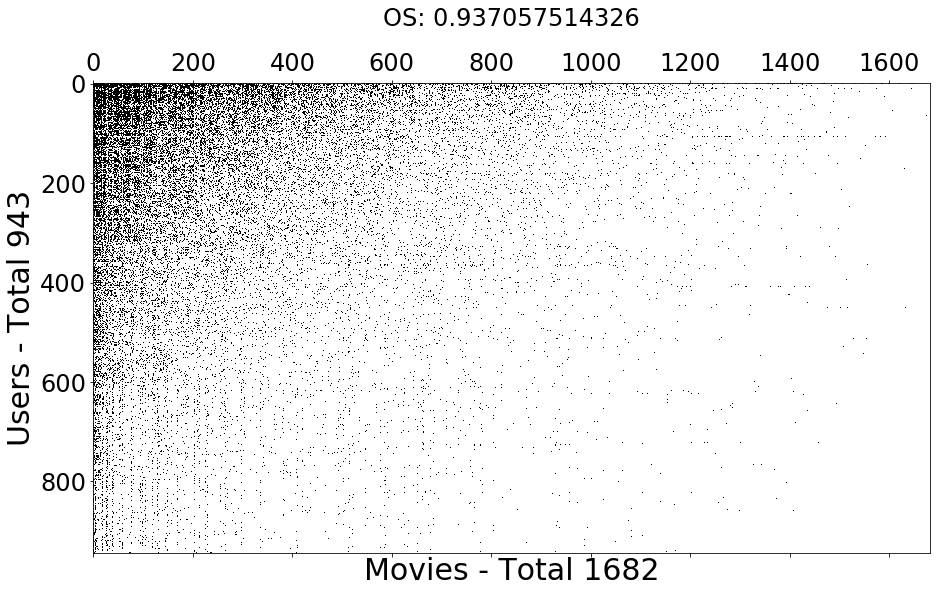

In [49]:
# Visualizing Items Sorted Matrix Sparsity
time_zero = time.time();

%matplotlib inline

OS = calculateOverallSparsityMeasure(R);
fig, ax = plt.subplots(figsize = (15,15));

ax.spy(R);

plt.xlabel("Movies - Total "+str(R.shape[1]-1), fontsize = 30)
plt.ylabel("Users - Total "+str(R.shape[0]-1), fontsize = 30)
plt.title("OS: " + str(OS) + '\n', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=24)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'itemsAndUsersSortedUtilityMatrix.png')
print "[+] Results saved."

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h2>Creating Utility Matrix Back-up</h2>
In case you want to go back to an utility matrix state, use the cells below

In [21]:
########################################################
# Creating back-up! Run this cell only if you want to 
# save your current utility matrix state.
########################################################
time_zero = time.time()

R_copy = np.copy(R);
print "Utility Matrix Copy Shape: ", R_copy.shape;
print "Elapsed time: ", time.time()-time_zero;

print R_copy

Utility Matrix Copy Shape:  (944, 1683)
Elapsed time:  0.0161199569702
[[ 5.  0.  0. ...,  1.  0.  0.]
 [ 4.  2.  3. ...,  0.  0.  0.]
 [ 5.  4.  5. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  3. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [22]:
# Getting back-up point
time_zero = time.time();
R = np.copy(R_copy)
print "Utility Matrix shape: ", R.shape
print "Elapsed time: ", time.time()-time_zero;
print R;

Utility Matrix shape:  (944, 1683)
Elapsed time:  0.0143730640411
[[ 5.  0.  0. ...,  1.  0.  0.]
 [ 4.  2.  3. ...,  0.  0.  0.]
 [ 5.  4.  5. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  3. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


<h1>Chopping Utility Matrix</h1>
In order to analyse how our overall sparsity changes by reducing users or items, we can chop our utility matrix according to 2 strategies:
- Chopping Users/Items by Specific Sparsity: we will only maintain those users/items with specific sparsity less than a defined threshold;
- Chopping Users/Items by Quantity: we will only maintain a certain amount of users/items according to our desired utility matrix shape.

In [23]:
# Auxiliary Functions

def chopUsersByUSS(matrix, lastUserUSS):
    """Returns utility matrix after dropping users with USS greater than 
    the last USS."""  
    
    if lastUserUSS <= 0:
        return matrix[0:1];
    
    if lastUserUSS >= 1:
        return matrix;
                
    usersSparsityArray = calculateUsersSpecificSparsityMeasure(matrix);    
    usersSparsityArray = np.sort(usersSparsityArray);       
        
    if lastUserUSS > usersSparsityArray[-1]:        
        return matrix;    
    
    lastUserIndex = np.argmax(usersSparsityArray >= lastUserUSS);           
    
    return matrix[:lastUserIndex]; 

def chopItemsByISS(matrix, lastItemISS):
    """Returns utility matrix after dropping items with ISS greater than 
    the last ISS."""
    
    if lastItemISS >= 1:
        return matrix;
    if lastItemISS <= 0:
        tempMatrix = np.array(matrix[:,0]);
        tempMatrix = np.reshape(tempMatrix, (matrix.shape[0],1));
        return tempMatrix;
        
    itemsSparsityArray = calculateItemsSpecificSparsityMeasure(matrix);    
    itemsSparsityArray = np.sort(itemsSparsityArray);        
    
    if lastItemISS > itemsSparsityArray[-1]:
        return matrix;
    
    lastItemIndex = np.argmax(itemsSparsityArray >= lastItemISS);
    
    tempMatrix = np.array(matrix[:,:lastItemIndex]);
    
    if lastItemIndex == 0:        
        tempMatrix = np.reshape(tempMatrix, (matrix.shape[0],1));
        
    return tempMatrix;
        
@np.vectorize    
def calculateOverallSparsityBySpecific(lastUserUSS, lastItemISS):
    """Calculates OS after chopping utility matrix given the last user's 
    and item's specific sparsity."""
    # Creating a copy of utility matrix so we don't 
    # mess with the original one (just in case)
    matrix = np.copy(R); 
    
    # Chopping utility matrix
    matrix = chopItemsByISS(matrix, lastItemISS);    
    matrix = chopUsersByUSS(matrix, lastUserUSS);        
    
    # Calculating chopped utility matrix overall sparsity
    result = calculateOverallSparsityMeasure(matrix);
    
    return result;    

<h2>Analysing Users Quantity given USS threshold</h2>
What happens to our users amount if we only keep those users with USS value less than a specific threshold ?

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  3.548817873


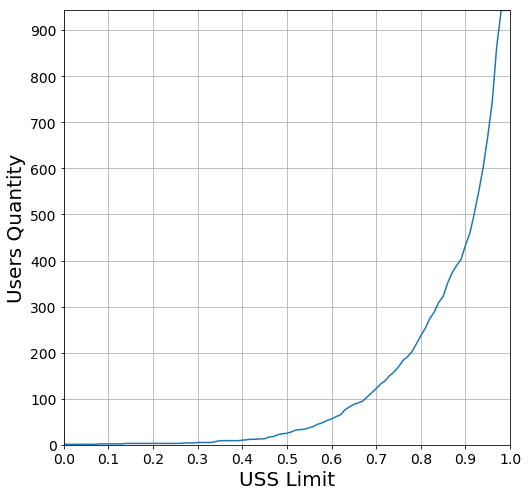

In [24]:
time_zero = time.time();

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])

usersQuantity = []
for sparsityLimit in sparsityChops:
    chopedMatrix = np.copy(R);
    chopedMatrix = chopUsersByUSS(chopedMatrix, sparsityLimit);
    usersQuantity.append(chopedMatrix.shape[0]);

%matplotlib inline

#plt.plot(sparsityChops, usersQuantity, '-')
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(sparsityChops, usersQuantity)
ax.axis([0, sparsityChops[-1], 0, usersQuantity[-1]])
ax.grid(True)
ax.set_xticks([x/100.0 for x in xrange (0, 110, 10)])
ax.set_yticks([x for x in xrange (0, usersQuantity[-1], 100)])
ax.set_xlabel('USS Limit', fontsize = 20)
ax.set_ylabel('Users Quantity', fontsize = 20)
#ax.set_title('Users Quantity x Users Sparsity Limit', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=14)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'usersQuantityXusersSparsity.png')
print "[+] Results saved.";
print "Elapsed time: ", time.time()-time_zero;

In [25]:
# Getting Users Quantity by Sparsity
time_zero = time.time();

usersQuantityThreshold = 900;

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])
for sparsityLimit in sparsityChops:
    chopedMatrix = np.copy(R);
    chopedMatrix = chopUsersByUSS(chopedMatrix, sparsityLimit);
    if chopedMatrix.shape[0] > usersQuantityThreshold:
        break;
    
print "USS limit to have ", usersQuantityThreshold, " users: ", sparsityLimit;
print "Number of users: ", chopedMatrix.shape[0];
print "Elapsed time: ", time.time()-time_zero;

USS limit to have  900  users:  0.98
Number of users:  943
Elapsed time:  3.25482320786


<h2>Analysing Items Quantity given ISS threshold</h2>
What happens to our items amount if we only keep those items with ISS value less than a specific threshold ?

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  2.36304593086


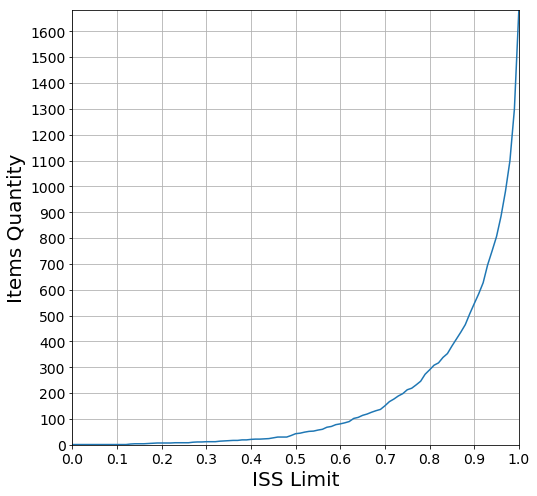

In [26]:
time_zero = time.time();

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])

itemsQuantity = []
for sparsityLimit in sparsityChops:
    chopedMatrix = np.copy(R);
    chopedMatrix = chopItemsByISS(chopedMatrix, sparsityLimit);
    itemsQuantity.append(chopedMatrix.shape[1]);

%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(sparsityChops, itemsQuantity)
ax.axis([0, sparsityChops[-1], 0, itemsQuantity[-1]])
ax.grid(True)
ax.set_xticks([x/100.0 for x in xrange (0, 110, 10)])
ax.set_yticks([x for x in xrange (0, itemsQuantity[-1], 100)])

ax.set_xlabel('ISS Limit', fontsize = 20)
ax.set_ylabel('Items Quantity', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
#ax.set_title('Items Quantity x Items Sparsity Limit', fontsize = 15)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'itemsQuantityXitemsSparsity.png')
print "[+] Results saved.";
print "Elapsed time: ", time.time()-time_zero;

In [27]:
# Getting Items Quantity by Sparsity
time_zero = time.time();

itemsQuantityThreshold = 900;

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])
for sparsityLimit in sparsityChops:
    chopedMatrix = np.copy(R);
    chopedMatrix = chopItemsByISS(chopedMatrix, sparsityLimit);
    if chopedMatrix.shape[1] > itemsQuantityThreshold:
        break;
    
print "ISS limit to have ", itemsQuantityThreshold, " items: ", sparsityLimit;
print "Number of items: ", chopedMatrix.shape[1];
print "Elapsed time: ", time.time()-time_zero;

ISS limit to have  900  items:  0.97
Number of items:  981
Elapsed time:  1.54236888885


<h2>Chopping Utility Matrix by Specific Sparsity</h2>
What happens to our utility matrix OS if we chop items and/or users by their specific sparsity?

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.466495037079


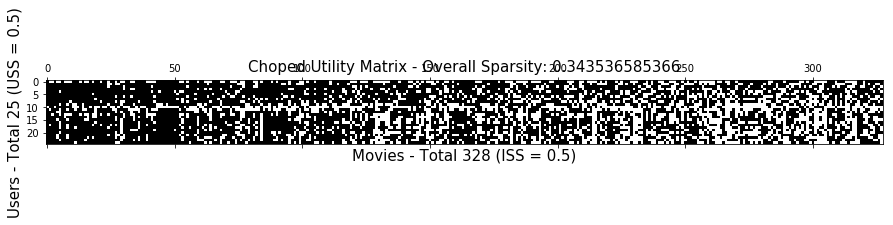

In [36]:
# Visualizing Items Sorted Matrix Sparsity
time_zero = time.time();

%matplotlib inline

usersUSSlimit = 0.5;
itemsISSlimit = 0.5;

chopedMatrix = np.copy(R);
chopedMatrix = chopUsersByUSS(chopedMatrix, usersUSSlimit);
chopedMatrix = chopItemsByISS(chopedMatrix, itemsISSlimit);

OS = calculateOverallSparsityMeasure(chopedMatrix);
fig, ax = plt.subplots(figsize = (15,15));

ax.spy(chopedMatrix);

plt.xlabel("Movies - Total "+str(chopedMatrix.shape[1]) + " (ISS = " + str(itemsISSlimit) + ")", fontsize = 15)
plt.ylabel("Users - Total "+str(chopedMatrix.shape[0]) + " (USS = " + str(usersUSSlimit) + ")", fontsize = 15)
plt.title("Choped Utility Matrix - Overall Sparsity: " + str(OS), fontsize = 15)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'chopedUtilityMatrix.png')

print "[+] Results saved."

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h3>Visualizing OS effect due to Specific Sparsity changes</h3>

[*] Saving variable to ./Results/Variables/100k/OS-3d-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/OS-3d-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/OS-3d-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving 3d-chopSparsityMeasures.png figure to ./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  2.60768699646


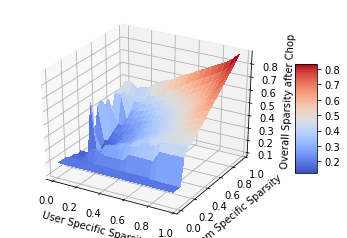

In [107]:
time_zero = time.time();

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.array([a/100.0 for a in xrange(1,100,5)])
B = np.array([b/100.0 for b in xrange(1,100,5)])

A, B = np.meshgrid(A, B)

#Processing data
Z = calculateOverallSparsityBySpecific (A, B);

var_A_filename = 'OS-3d-A_meshgrid.csv'
var_B_filename = 'OS-3d-B_meshgrid.csv'
var_Z_filename = 'OS-3d-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel('Overall Sparsity after Chop')

filename = '3d-chopSparsityMeasures.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

In [149]:
granularity = 5

X = np.array([a/100.0 for a in xrange(0,101, granularity)]) # user
Y = np.array([b/100.0 for b in xrange(100,-1, -granularity)]) # item
#print X
#print Y

Zline = np.array([])
firstLine = True

for y in xrange(len(Y)):
    Zline = np.array([]);
    for x in xrange(len(X)):
        element = calculateOverallSparsityBySpecific (X[x], Y[y]); #user, item
        Zline = np.append(Zline, element)
    if firstLine:
        Z = np.array([Zline])
        firstLine = False
    else:
        Z = np.append(Z, [Zline], axis = 0)    
    
    #print Zline
#print Zline.shape
print Z.shape
#print Z

(21, 21)


In [187]:
#Plotting 2-D evaluation graph

granularity = 1

# Make data.
A = np.array([a/100.0 for a in xrange(1,100,granularity)])
B = np.array([b/100.0 for b in xrange(1,100,granularity)])

A, B = np.meshgrid(A, B)

#Processing data
Z = calculateOverallSparsityBySpecific (A, B);


In [188]:
print Z.shape
print calculateOverallSparsityBySpecific(0.1, 0.1)

(99, 99)
0.195540308748


[*] Saving 2d-ISSxUSSxOS.png figure to ./Results/Figures/100k/ folder...
[+] Results saved.


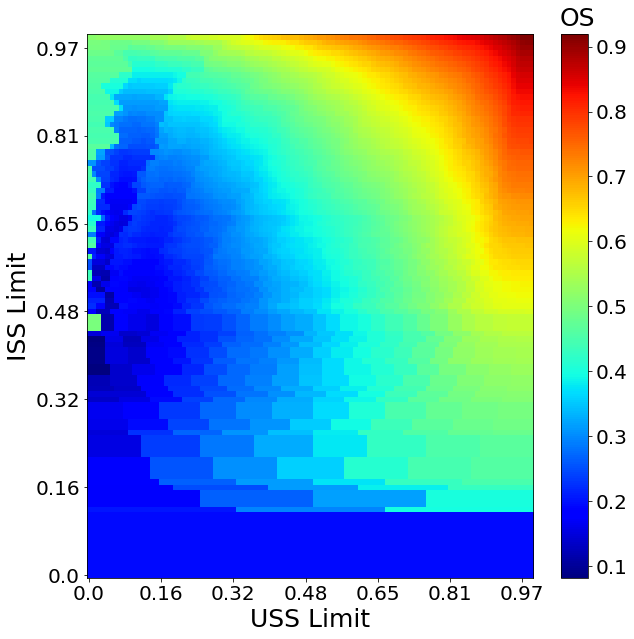

In [228]:
%matplotlib inline

A = np.array([a/100.0 for a in xrange(0,100,granularity)])
B = np.array([b/100.0 for b in xrange(0,100,granularity)])

fig, ax = plt.subplots(figsize=(10,10))

cax = ax.imshow(Z[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()

numberOfTicks = 6

labels = [x/float(Z.shape[0]) for x in xrange(0,Z.shape[0],Z.shape[0]/numberOfTicks)]
for l in xrange(len(labels)):
    labels[l] = float("{0:.2f}".format(labels[l]))
    
plt.xticks(np.arange(0, Z.shape[0], Z.shape[0]/numberOfTicks))
plt.yticks(np.arange(0, Z.shape[1], Z.shape[0]/numberOfTicks))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Setting Labels
tick_fontsize = 20
label_fontsize = 25
ax.set_xlabel('USS Limit', fontsize = label_fontsize)
ax.set_ylabel('ISS Limit', fontsize = label_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

cbar = fig.colorbar(cax)
cbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)



# Saving figure
filename = '2d-ISSxUSSxOS.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
print "[+] Results saved.";

In [120]:
#print calculateOverallSparsityBySpecific(0.1, 0.9)
print Z

[[ 0.19554031  0.19554031  0.19554031 ...,  0.19554031  0.19554031
   0.19554031]
 [ 0.19554031  0.19554031  0.19554031 ...,  0.19554031  0.19554031
   0.19554031]
 [ 0.19554031  0.19554031  0.19554031 ...,  0.19554031  0.19554031
   0.19554031]
 ..., 
 [ 0.49541284  0.49541284  0.49541284 ...,  0.89650442  0.89650442
   0.89650442]
 [ 0.49863512  0.49863512  0.49863512 ...,  0.90593263  0.90601405
   0.90601405]
 [ 0.51540832  0.51540832  0.52118644 ...,  0.91909243  0.91909243
   0.91909243]]


<h1>Testing Algorithms According to Sparsity</h1>
Now that we've set how we can change our OS due to specific sparsities, we can analyse how a recommender system is affected if we work on a certain sparsity zone.

<h3>Auxiliary Function</h3>

In [55]:
#Importing Libs
from surprise import NMF
from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset
from surprise import evaluate, print_perf
import surprise
#Creating dataset to use in surprise lib format
def createUtilityMatrixPandasDataset(matrix):
    new_dataframe = pd.DataFrame()
    global usersIds;
    global moviesIds;
    
    stringUsersIds = [];
    stringMoviesIds = [];
    stringEvaluations = [];
    
    for userCount in xrange(len(matrix)):
        for itemCount in xrange(len(matrix[userCount])):
            if matrix[userCount][itemCount] != 0:
                stringUsersIds.append(usersIds[userCount]);
                stringMoviesIds.append(moviesIds[itemCount]);
                stringEvaluations.append(str(int(matrix[userCount][itemCount])));
    
    new_dataframe['userId'] = stringUsersIds;    
    new_dataframe['movieId'] = stringMoviesIds;
    new_dataframe['rating'] = stringEvaluations;
    return new_dataframe;

###################################################################
# Keep in mind the number of folds used in cross validation!
###################################################################

def getAlgorithmEvaluations(algorithmName, USSLimit, ISSLimit, number_of_folds = 10):
    algorithms = [KNNBasic(),  SVD(), NMF()];
    algorithmsNames = np.array(['KNNBasic', 'SVD', 'NMF']);
    #number_of_folds = 5;
    
    if algorithmName not in algorithmsNames:
        print algorithmName, " is not on the algorithms list.";
        return -1;
    
    global R;
    chopedMatrix = np.copy(R);
    chopedMatrix = chopUsersByUSS(chopedMatrix, USSLimit);
    chopedMatrix = chopItemsByISS(chopedMatrix, ISSLimit);

    OS = calculateOverallSparsityMeasure(chopedMatrix);
    shape = chopedMatrix.shape;
    
    df = createUtilityMatrixPandasDataset(chopedMatrix);

    tempFilePath = results_path+'Variables/'+'tempData.csv';
    with open(tempFilePath, "w") as fout:
        head = 'userId,movieId,rating\n';
        fout.write(head);
        for registerCount in xrange(df.shape[0]):
            line = str(df['userId'][registerCount])+','+str(df['movieId'][registerCount])+','+str(df['rating'][registerCount])+'\n';
            fout.write(line);

    r = surprise.dataset.Reader(sep=',', skip_lines=1);
    data = Dataset.load_from_file(tempFilePath, r);    
    data.split(n_folds=number_of_folds)

    # Evaluate performances of our algorithm on the dataset.
    algo = algorithms[np.where(algorithmsNames == algorithmName)[0][0]];
    
    perf = evaluate(algo, data, measures=['RMSE', 'MAE'], verbose=0)

    maeMeans = np.mean(perf['MAE'])
    maeStd = np.std(perf['MAE'])
    rmseMeans = np.mean(perf['RMSE'])
    rmseStd = np.std(perf['RMSE'])
    
    returnArray = [algorithmName, USSLimit, ISSLimit, shape[0], shape[1], OS, maeMeans, maeStd, rmseMeans, rmseStd];
    
    return returnArray;


In [42]:
#Testing Functions
print getAlgorithmEvaluations('NMF', 1.0, 1.0);
print getAlgorithmEvaluations('SVD', 1.0, 1.0);

['NMF', 1.0, 1.0, 944, 1683, 0.9370575143257097, 0.75338961428624285, 0.0036439390761075162, 0.95716810560597554, 0.0056033133386036264]
['SVD', 1.0, 1.0, 944, 1683, 0.9370575143257097, 0.73244078379633426, 0.0050351077681503658, 0.92945035653122743, 0.0054487575581407422]


In [41]:
print getAlgorithmEvaluations('NMF', 0.9, 1.0);
print getAlgorithmEvaluations('SVD', 0.9, 1.0);

['NMF', 0.9, 1.0, 433, 1683, 0.8897286957333147, 0.74133916423439938, 0.0083301823311252802, 0.9428258850088127, 0.0084605054966080378]
['SVD', 0.9, 1.0, 433, 1683, 0.8897286957333147, 0.72189912999594485, 0.0079261057164199279, 0.91694515923546827, 0.0077892036013765247]


In [46]:
print getAlgorithmEvaluations('NMF', 0.6, 1.0);
print getAlgorithmEvaluations('SVD', 0.6, 1.0);

['NMF', 0.6, 1.0, 56, 1683, 0.7703717850776675, 0.78253744317944718, 0.0088548043367941837, 1.0038921871456965, 0.010322211857547928]
['SVD', 0.6, 1.0, 56, 1683, 0.7703717850776675, 0.74448738297768124, 0.013220114539088213, 0.94538692985104722, 0.016833942613332306]


In [43]:
print getAlgorithmEvaluations('NMF', 1.0, 0.9);
print getAlgorithmEvaluations('SVD', 1.0, 0.9);

['NMF', 1.0, 0.9, 944, 546, 0.8435501645247407, 0.73508338065865941, 0.0056858675971800388, 0.93295674475512058, 0.0072000797186252677]
['SVD', 1.0, 0.9, 944, 546, 0.8435501645247407, 0.71762841556942736, 0.006485263147373705, 0.91378843643742813, 0.0082841706451311902]


In [47]:
print getAlgorithmEvaluations('NMF', 1.0, 0.6);
print getAlgorithmEvaluations('SVD', 1.0, 0.6);

['NMF', 1.0, 0.6, 944, 81, 0.6640772128060264, 0.74307511858113595, 0.0097088291530792199, 0.94810401777201181, 0.012570690730121089]
['SVD', 1.0, 0.6, 944, 81, 0.6640772128060264, 0.71486594084552968, 0.0056001943353271412, 0.9146756674913229, 0.0065009165487132274]


In [57]:
print getAlgorithmEvaluations('NMF', 0.9, 0.9);
print getAlgorithmEvaluations('SVD', 0.9, 0.9);

['NMF', 0.9, 0.9, 433, 658, 0.7597555753666019, 0.72504854097392823, 0.0074385855098863312, 0.92061062359548773, 0.0095934668989926374]


KeyboardInterrupt: 

In [50]:
print getAlgorithmEvaluations('NMF', 0.6, 0.6);
print getAlgorithmEvaluations('SVD', 0.6, 0.6);

['NMF', 0.6, 0.6, 56, 377, 0.41938234179613487, 0.72375978602203872, 0.012546548095552622, 0.9251481204790537, 0.010211220247370109]
['SVD', 0.6, 0.6, 56, 377, 0.41938234179613487, 0.71154932734941057, 0.016766395403703449, 0.90848256950957418, 0.016348892334811679]


<h3>Getting Algorithm Evaluations</h3>

In [ ]:
time_zero = time.time();

#algorithmsNames = ['SVD', 'KNNBasic', 'NMF'];
algorithmsNames = ['SVD', 'NMF']; # Which algorithms you would like to evaluate
usersUSSLimits = np.array([x/100.0 for x in xrange(1, 101, 1)]);
itemsISSLimits = np.array([x/100.0 for x in xrange(1, 101, 1)]);

algorithmsResults = [];
messages = []

for alg in algorithmsNames:
    time_one = time.time();
    for userUSS in usersUSSLimits:
        for itemISS in itemsISSLimits: 
            result = getAlgorithmEvaluations(alg, userUSS, itemISS)            
            algorithmsResults.append(result);
    
    message = "Elapsed time for "+ str(alg) + ": "+ str(time.time()-time_one) + " s";
    print message
    messages.append(message)
    bot.sendMessage(messages)
    
algorithmsResults = np.array(algorithmsResults);

message = "Algorithms evaluations has finished. "
bot.sendMessage(messages)
print "Elapsed time: ", time.time()-time_zero;

In [ ]:
#Creating dataframe to save evaluations and saving it to file.
algorithmsDataframe = pd.DataFrame()

#  algorithmsResults data:
#  [Algorithm, USSLimit, ISSLimit, shape[0], shape[1], OS, maeMeans, maeStd, rmseMeans, rmseStd];
algorithmsDataframe['Algorithm'] = algorithmsResults[:,0];
algorithmsDataframe['USS'] = algorithmsResults[:,1];
algorithmsDataframe['ISS'] = algorithmsResults[:,2];
algorithmsDataframe['users'] = algorithmsResults[:,3];
algorithmsDataframe['items'] = algorithmsResults[:,4];
algorithmsDataframe['OS'] = algorithmsResults[:,5];
algorithmsDataframe['MAEmeans'] = algorithmsResults[:,6];
algorithmsDataframe['MAEstd'] = algorithmsResults[:,7];
algorithmsDataframe['RMSEmeans'] = algorithmsResults[:,8];
algorithmsDataframe['RMSEstd'] = algorithmsResults[:,9];

path = results_path+'Variables/'+dataset
filename = 'algorithmsResults.csv';
print "[*] Saving " + filename + " file to " + path + " folder..."
algorithmsDataframe.to_csv(path+filename);
print "[+] Results saved."

In [233]:
ussProfiles = {
    'Very Tight': '0.68',
    'Tight' : '0.78',
    'Medium': '0.89',
    'Loose' : '0.97',
    'Very Loose': '0.98'}

ussProfilesNames = ['Very Tight', 'Tight', 'Medium', 'Loose', 'Very Loose']
for u in ussProfilesNames:
    print ussProfiles[u]


0.68
0.78
0.89
0.97
0.98


In [237]:
time_zero = time.time()
ussProfiles = {
    'Very Tight': '0.68',
    'Tight' : '0.78',
    'Medium': '0.89',
    'Loose' : '0.97',
    'Very Loose': '0.98'}
ussProfilesNames = ['Very Tight', 'Tight', 'Medium', 'Loose', 'Very Loose']
issProfiles = {
    'Very Tight': '0.63',
    'Tight' : '0.75',
    'Medium': '0.86',
    'Loose' : '0.95',
    'Very Loose': '0.97'}
issProfilesNames = ['Very Tight', 'Tight', 'Medium', 'Loose', 'Very Loose']

print "=== SVD ===\n"    

for alg in algorithmsNames:
    print "\n",alg," - RMSE:"
    for uProfileName in ussProfilesNames:
        line = "\\textbf{"+uProfileName+"}";        
        for iProfileName in issProfilesNames:                        
            for register in xrange(len(algorithmsDataframe['Algorithm'])):
                if algorithmsDataframe['Algorithm'][register] == alg and algorithmsDataframe['USS'][register] == ussProfiles[uProfileName] and algorithmsDataframe['ISS'][register] == issProfiles[iProfileName]:
                    #print  uProfileName,'\t& ',iProfileName,'\t&\t$',algorithmsDataframe['RMSEmeans'][register][:5], '\pm',  algorithmsDataframe['RMSEstd'][register][:5],'$', '\\\\';
                    line = line + " & $" + algorithmsDataframe['RMSEmeans'][register][:5] + ' \pm ' +  algorithmsDataframe['RMSEstd'][register][:5]+'$'
        line = line + " \\\\"            
        print line
        
"""print "\n=== MAE ===\n"    
for alg in algorithmsNames:
    print alg," - MAE: "
    for uProfileName in ussProfiles:
        for iProfileName in issProfiles:
            for register in xrange(len(algorithmsDataframe['Algorithm'])):
                if algorithmsDataframe['Algorithm'][register] == alg and algorithmsDataframe['USS'][register] == ussProfiles[uProfileName] and algorithmsDataframe['ISS'][register] == issProfiles[iProfileName]:
                    print  uProfileName,'\t& ',iProfileName,'\t&\t$',algorithmsDataframe['MAEmeans'][register][:5], '\pm',  algorithmsDataframe['MAEstd'][register][:5],'$', '\\\\';
"""                 
print "Elapsed time: ", time.time()-time_zero;                    

=== SVD ===


SVD  - RMSE:
\textbf{Very Tight} & $0.890 \pm 0.013$ & $0.898 \pm 0.014$ & $0.907 \pm 0.011$ & $0.922 \pm 0.011$ & $0.924 \pm 0.009$ \\
\textbf{Tight} & $0.882 \pm 0.008$ & $0.891 \pm 0.011$ & $0.899 \pm 0.010$ & $0.909 \pm 0.008$ & $0.912 \pm 0.008$ \\
\textbf{Medium} & $0.882 \pm 0.016$ & $0.885 \pm 0.009$ & $0.897 \pm 0.007$ & $0.909 \pm 0.007$ & $0.911 \pm 0.007$ \\
\textbf{Loose} & $0.905 \pm 0.016$ & $0.898 \pm 0.012$ & $0.907 \pm 0.010$ & $0.916 \pm 0.005$ & $0.921 \pm 0.005$ \\
\textbf{Very Loose} & $0.908 \pm 0.015$ & $0.901 \pm 0.012$ & $0.911 \pm 0.006$ & $0.919 \pm 0.005$ & $0.923 \pm 0.003$ \\

NMF  - RMSE:
\textbf{Very Tight} & $0.906 \pm 0.016$ & $0.918 \pm 0.013$ & $0.931 \pm 0.013$ & $0.952 \pm 0.014$ & $0.954 \pm 0.009$ \\
\textbf{Tight} & $0.894 \pm 0.013$ & $0.906 \pm 0.009$ & $0.916 \pm 0.012$ & $0.932 \pm 0.008$ & $0.935 \pm 0.011$ \\
\textbf{Medium} & $0.899 \pm 0.013$ & $0.903 \pm 0.009$ & $0.917 \pm 0.006$ & $0.929 \pm 0.006$ & $0.933 \pm 0.009$ \

<h2>Visualizing Algorihtms Evaluations</h2>

<h3>SVD - MAE</h3>

In [ ]:
# Making data arrays
A = np.array([])
B = np.array([])

Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)


NameError: name 'Z' is not defined

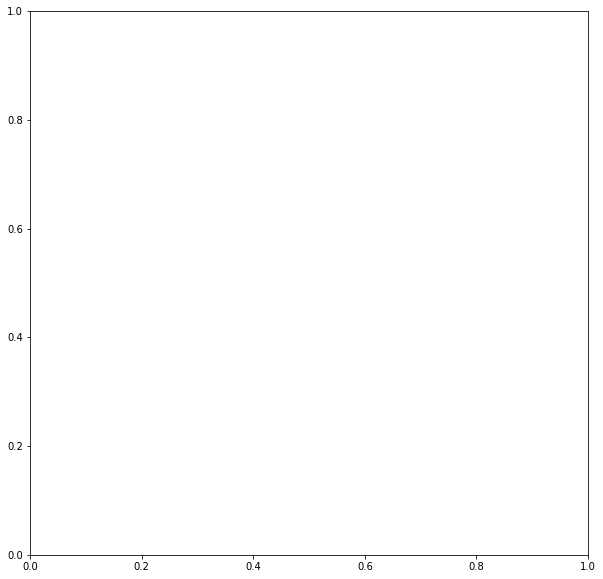

In [51]:
#Plotting 2-D evaluation graph
%matplotlib inline

algoName = 'SVD'
evaluationParameter = 'MAEmeans'

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(Z[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()
#ax.set_title(algoName+' - ' + evaluationParameter, fontsize = 18)

#Setting X ticks 
numberOfTicks = 6
labels = [A[0]+x*((A[-1]-A[0])/float(numberOfTicks)) for x in xrange(numberOfTicks+1)]
for l in xrange(len(labels)):
    labels[l] = float("{0:.2f}".format(labels[l]))
#ax.set_xticklabels(labels)


#Setting Y ticks 
numberOfTicks = 6
labels = [B[0]+x*((B[-1]-A[0])/float(numberOfTicks)) for x in xrange(numberOfTicks+1)]
for l in xrange(len(labels)):
    labels[l] = float("{0:.2f}".format(labels[l]))
#ax.set_yticklabels(labels)

tick_fontsize = 20
label_fontsize = 25

# Setting Labels
ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
cbar = fig.colorbar(cax)

ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
cbar.set_label('MAE', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)

# Saving figure
filename = '2d-'+algoName+'-'+evaluationParameter+'.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
print "[+] Results saved.";


[*] Saving variable to ./Results/Variables/100k/SVD-MAE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-MAE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-MAE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.41921710968


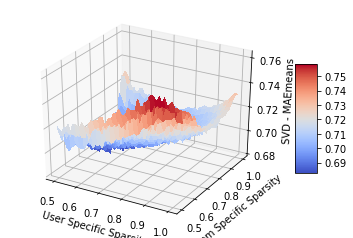

In [238]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'SVD'
evaluationParameter = 'MAEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
var_A_filename = 'SVD-MAE-A_meshgrid.csv'
var_B_filename = 'SVD-MAE-B_meshgrid.csv'
var_Z_filename = 'SVD-MAE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+algoName+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

<h3>SVD - RMSE</h3>

[*] Saving variable to ./Results/Variables/100k/SVD-RMSE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-RMSE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-RMSE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.359324932098


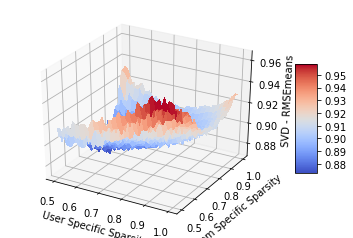

In [239]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'SVD'
evaluationParameter = 'RMSEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
var_A_filename = 'SVD-RMSE-A_meshgrid.csv'
var_B_filename = 'SVD-RMSE-B_meshgrid.csv'
var_Z_filename = 'SVD-RMSE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

<h3>NMF - MAE</h3>

[*] Saving variable to ./Results/Variables/100k/NMF-MAE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-MAE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-MAE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.324208021164


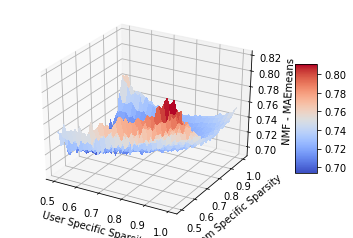

In [240]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'NMF'
evaluationParameter = 'MAEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
# Saving variables for future use
var_A_filename = 'NMF-MAE-A_meshgrid.csv'
var_B_filename = 'NMF-MAE-B_meshgrid.csv'
var_Z_filename = 'NMF-MAE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

<h3>NMF - RMSE</h3>

[*] Saving variable to ./Results/Variables/100k/NMF-RMSE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-RMSE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-RMSE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.364863872528


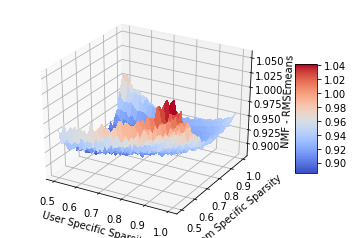

In [241]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'NMF'
evaluationParameter = 'RMSEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
var_A_filename = 'NMF-RMSE-A_meshgrid.csv'
var_B_filename = 'NMF-RMSE-B_meshgrid.csv'
var_Z_filename = 'NMF-RMSE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;